In [1]:
%load_ext autoreload
%matplotlib inline

# Area under PR-curve calculations/tests

Notebook to test the correctness of area under curve calculations.

In [2]:
import os, sys
import numpy as np
import pandas as pd
import sklearn.metrics
from IPython.display import display
sys.path.append(os.path.abspath(os.path.join('..')))

import plot.anomalies, plot.evaluation, plot.data, plot.features
from plot import pyplot as plt
from database.CERNMongoClient import CERNMongoClient
import pipeline.pipeline as pipeline
from anomaly_detection.factory import *
from evaluation import evaluation, segmentation
from feature_extraction import feature_extraction, preprocessing

db = CERNMongoClient()

# auto-load changes in imported modules
%autoreload 2

In [3]:
df = feature_extraction.load_features_from_file(beam=1)
labels = db.query_elogbook_no_info(beam=1)
len(labels)

Loading file '/home/n/masters-thesis/src/../data-cern/features-b1-'.
File not found, loading '/home/n/masters-thesis/src/../data-cern/features-b1-sw_10min-2018_05_17.csv' instead.

Fetching data for pattern MKI.ELOGBOOK_tagged from 2015-06-22 00:00:00 to 2016-09-14 00:00:00



77

In [4]:
# define custom area under curve calculations and compare to scikit-learn/numpy functions
def calculate_auc(results_df):
    y_true = results_df.y_true.astype('bool')
    thresholds = results_df.y_pred.astype('float').sort_values().unique()
    
    precisions = np.empty(shape=thresholds.size+1, dtype=np.float64)
    recalls = np.empty(shape=thresholds.size+1, dtype=np.float64)
    
    for i, tr in enumerate(thresholds):
        y_pred = (tr <= results_df.y_pred)

        (tn, fp), (fn, tp)  = sklearn.metrics.confusion_matrix(y_true, y_pred)

        precisions[i] = tp / (tp + fp)
        recalls[i] = tp / (tp + fn)
        
    precisions[-1] = 1
    recalls[-1] = 0
    
    sort_idx = np.argsort(recalls)
    print(
        "trapz 1:", np.trapz(recalls, precisions),
        "trapz 2:", np.trapz(y=precisions[sort_idx], x=recalls[sort_idx])
    )
    
    area = 0
    for i, (p, r) in enumerate(zip(precisions, recalls)):
        if i > 0:
            height = (p + precisions[i-1]) / 2
            width = abs(r - recalls[i-1])
            area += height*width
    print("area", area)
        
    plt.figure()
    plt.plot(recalls, precisions)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.00])
    plt.tight_layout(rect=(0, 0, 1, 0.98))
    plt.show()
        
    plt.figure()
    plt.plot(precisions, label="precision")
    plt.plot(recalls, label="recall")

    plt.xlabel("threshold index")
    plt.ylim([0.0, 1.05])
    plt.xlim([0, len(precisions)])
    plt.tight_layout(rect=(0, 0, 1, 0.98))
    plt.title('Precision and recall')
    plt.show()
    
    return area, precisions, recalls, thresholds

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None) 

| Trained detector and scored features: 2.0 seconds
| Created segments: 0.9 seconds
| Created results DataFrame: 1.0 seconds
| Results DataFrame check: 0.0 seconds


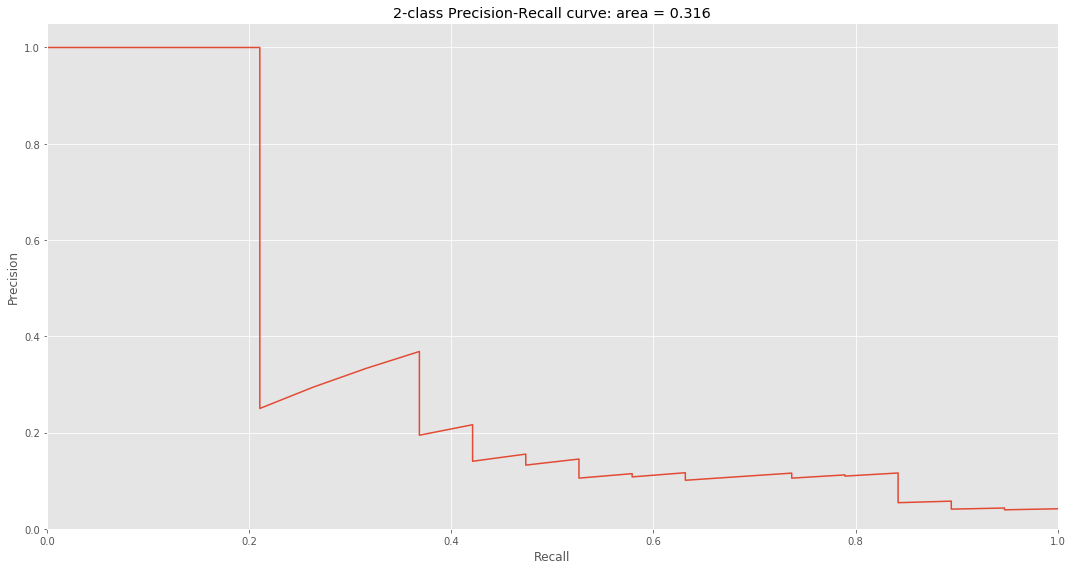

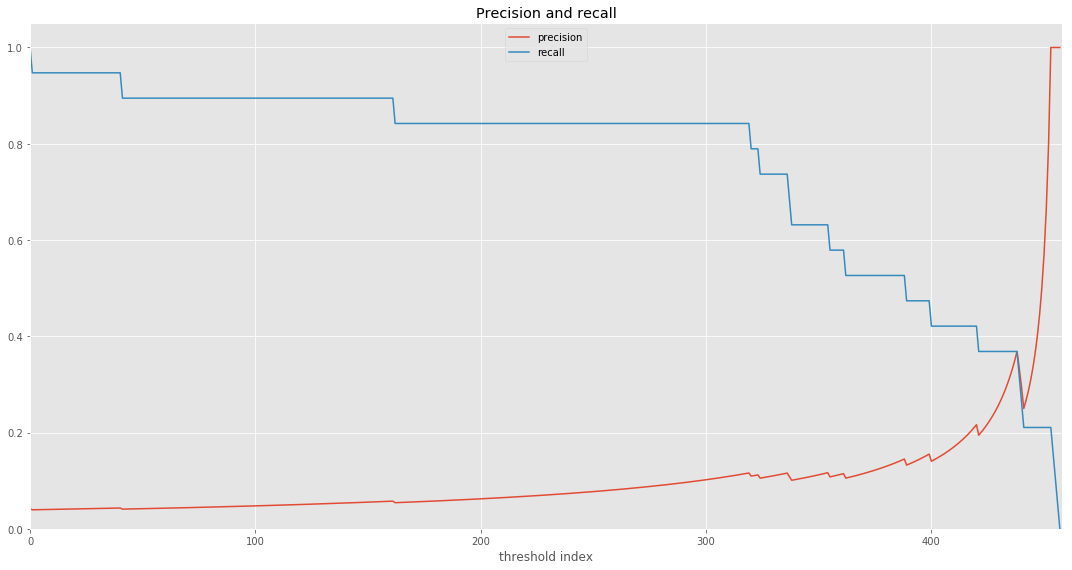

PR-curve tresholds: 457, min: 0.14, max: 1.00
Area under PR curve = 0.31599173770573524
| Evaluation: 0.3 seconds
| Pipeline execution time: 4.2 seconds



In [5]:
results, auc, precision, recall, thresholds = pipeline.pipeline(
    df, 
    labels,
    anomaly_detector="gmm",
    detector_parameters={"n_components": 2, "covariance_type": "full"},
    scale_data = True,
    verbose=True, 
    show_figures=True
)

trapz 1: 0.2960590094729821 trapz 2: 0.31685965915301184
area 0.3277256761396487


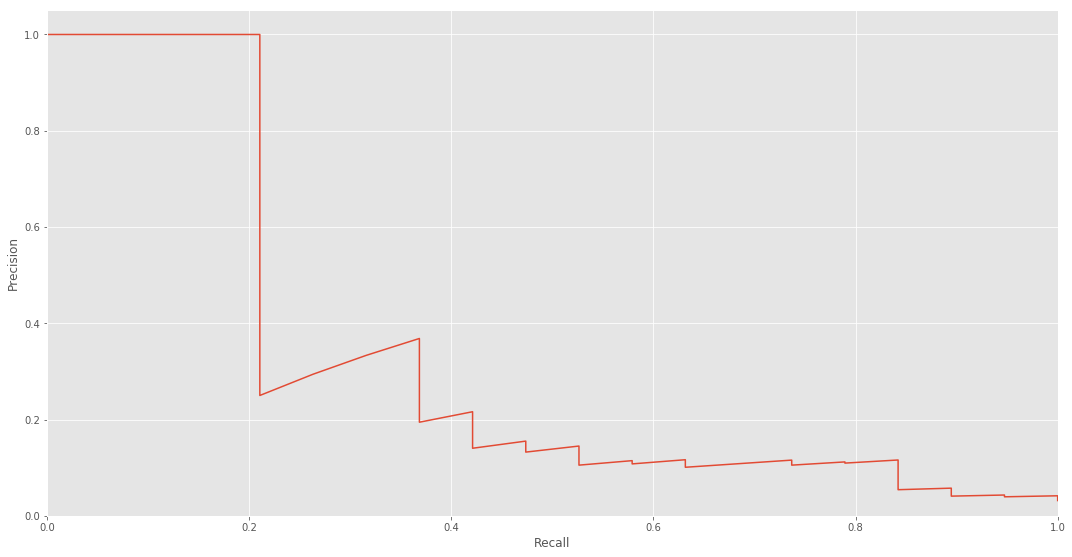

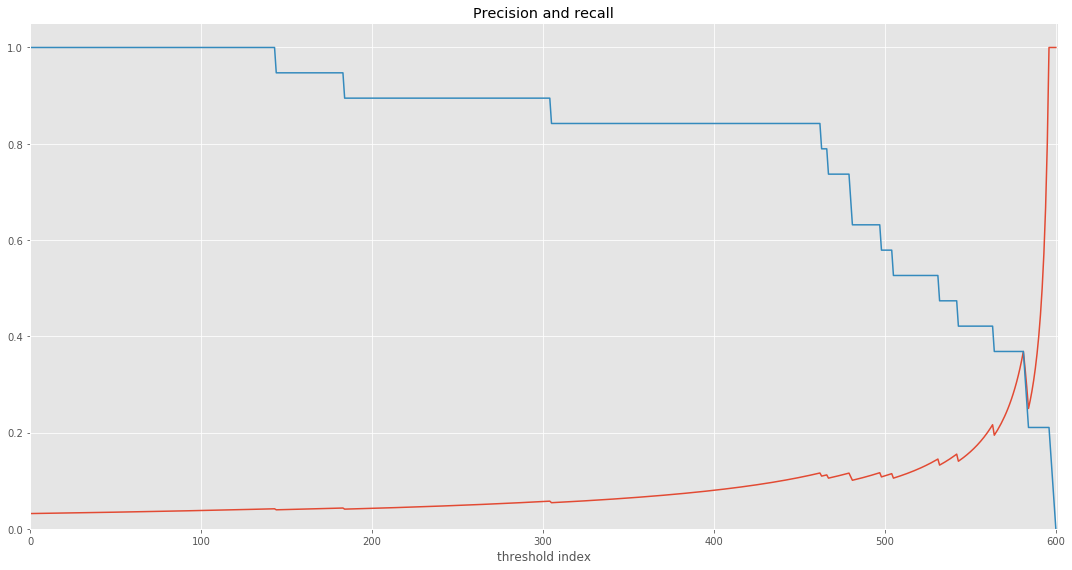

In [6]:
area, precisions, recalls, thresholds = calculate_auc(results)

IsolationForest(bootstrap=False, contamination=0.01, max_features=1.0,
        max_samples=750, n_estimators=1000, n_jobs=-1, random_state=None,
        verbose=False) 

| Trained detector and scored features: 40.3 seconds
| Created segments: 0.7 seconds
| Created results DataFrame: 1.0 seconds
| Results DataFrame check: 0.0 seconds


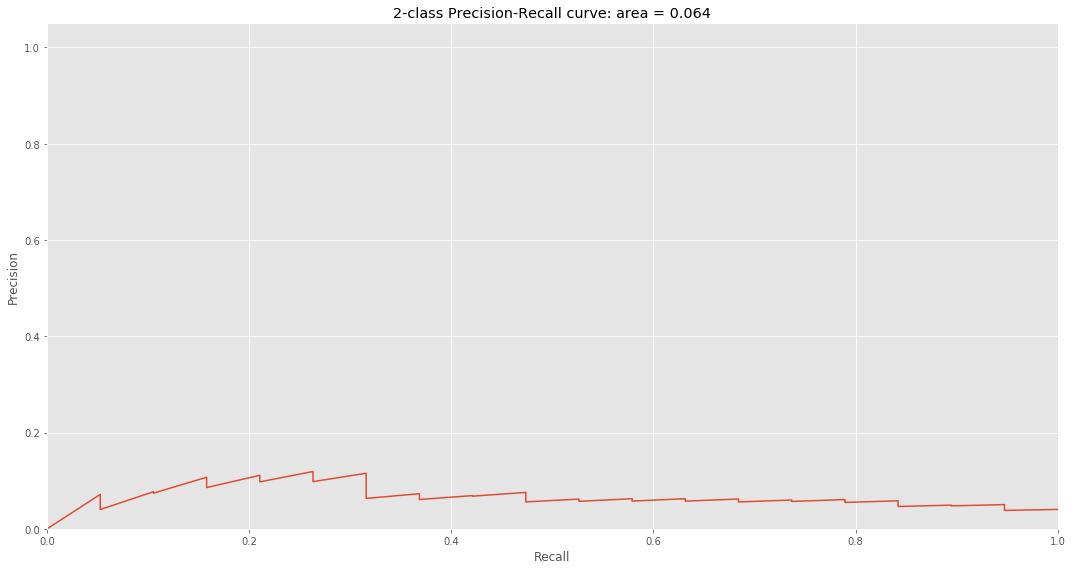

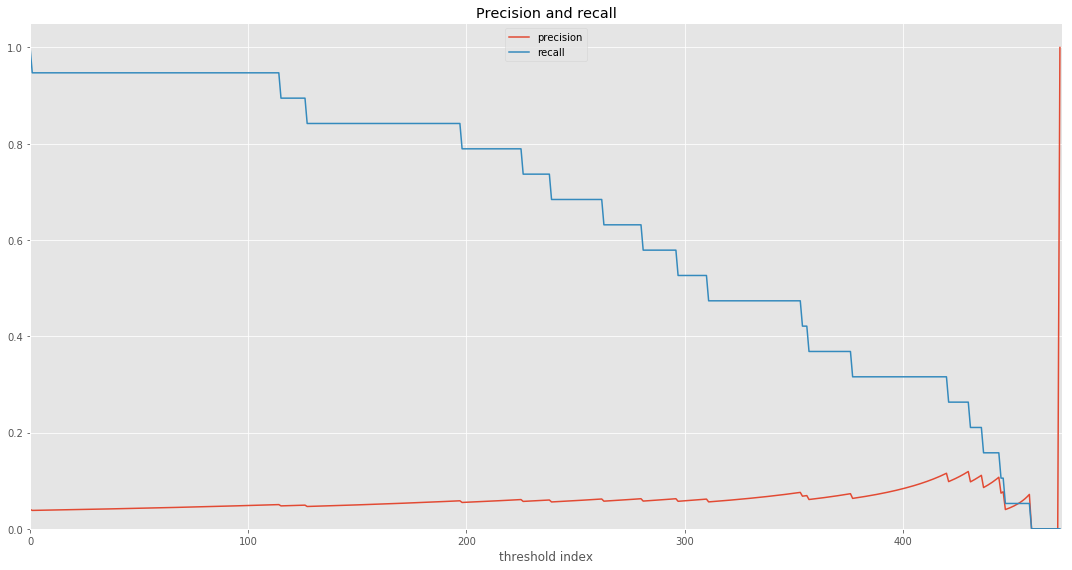

PR-curve tresholds: 472, min: 0.27, max: 1.00
Area under PR curve = 0.0644545786472179
| Evaluation: 0.3 seconds
| Pipeline execution time: 42.4 seconds



In [7]:
results, auc, precision, recall, thresholds = pipeline.pipeline(
    df, 
    labels,
    anomaly_detector="isolationforest",
    detector_parameters={"n_estimators": 1000, "max_samples": 750, "n_jobs": -1},
    scale_data = True,
    verbose=True, 
    show_figures=True
)

trapz 1: 0.03413636170380168 trapz 2: 0.06371893142765887
area 0.06580302837046835


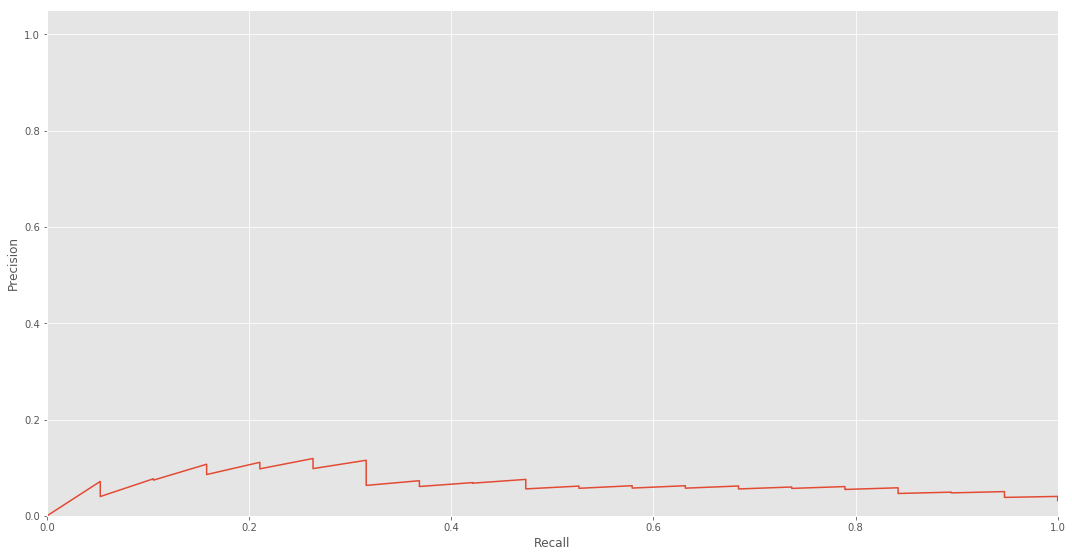

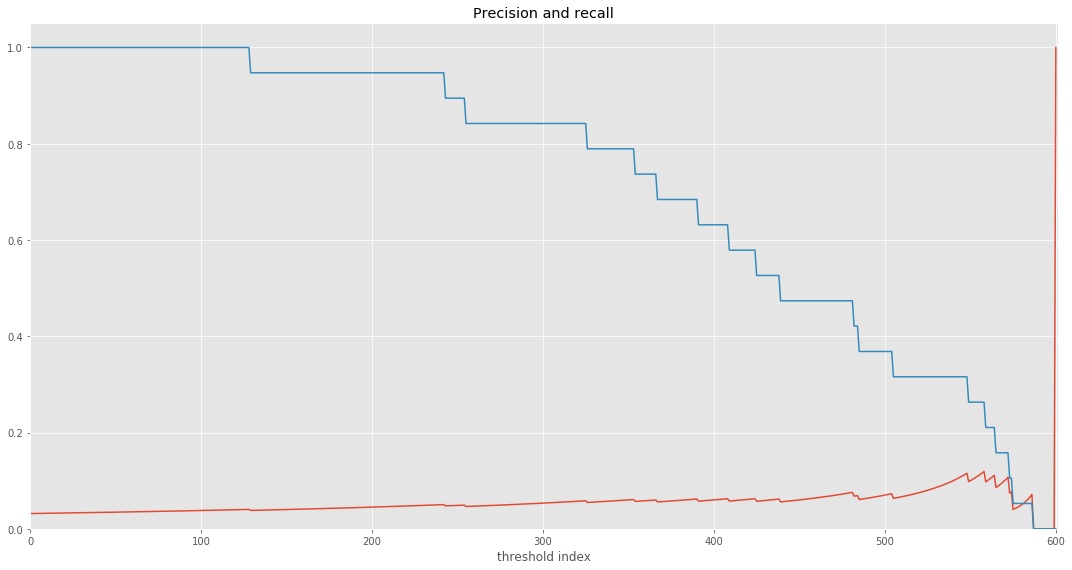

In [8]:
area, precisions, recalls, thresholds = calculate_auc(results)

DummyDetector(strategy='uniform', constant=None, contamination=0.01) 

| Trained detector and scored features: 0.1 seconds
| Created segments: 0.8 seconds
| Created results DataFrame: 1.1 seconds
| Results DataFrame check: 0.0 seconds


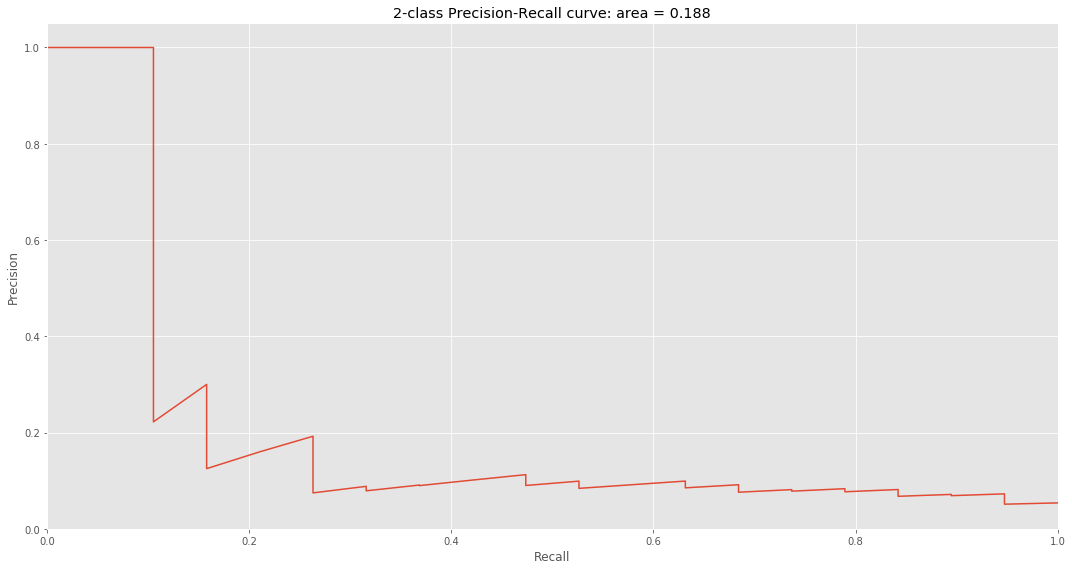

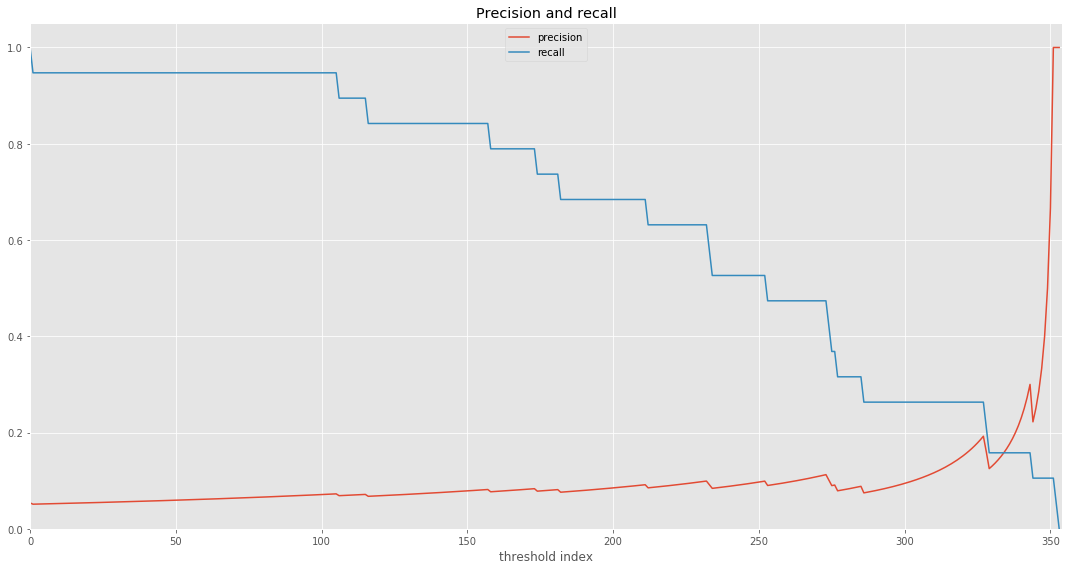

PR-curve tresholds: 353, min: 0.98, max: 1.00
Area under PR curve = 0.1878144064011183
| Evaluation: 0.3 seconds
| Pipeline execution time: 2.2 seconds



In [9]:
results, auc, precision, recall, thresholds = pipeline.pipeline(
    df, 
    labels,
    anomaly_detector="dummy_uniform",
    detector_parameters={},
    scale_data = True,
    verbose=True, 
    show_figures=True
)

trapz 1: 0.16549271085862513 trapz 2: 0.1900445964876884
area 0.19715937752529178


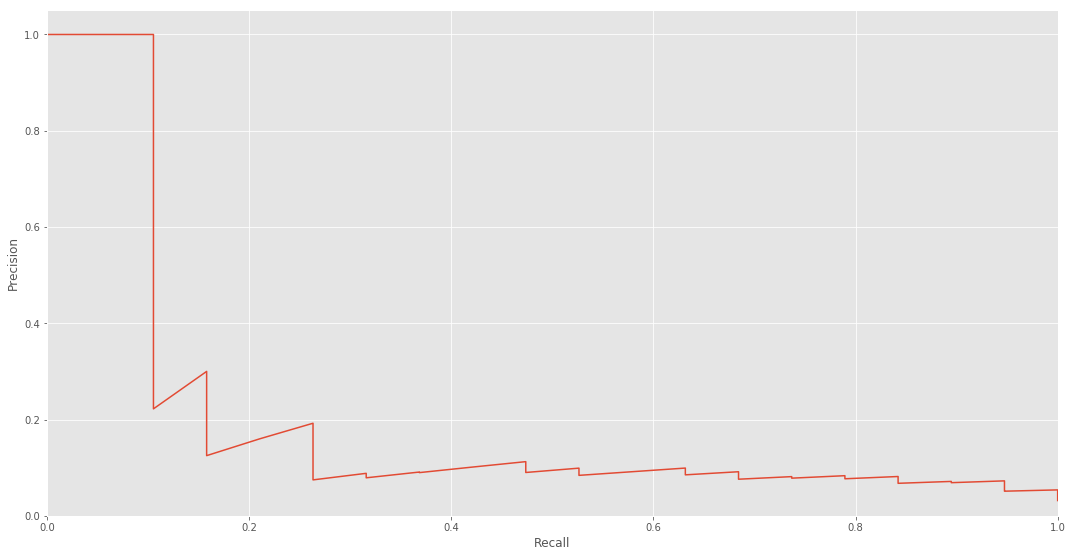

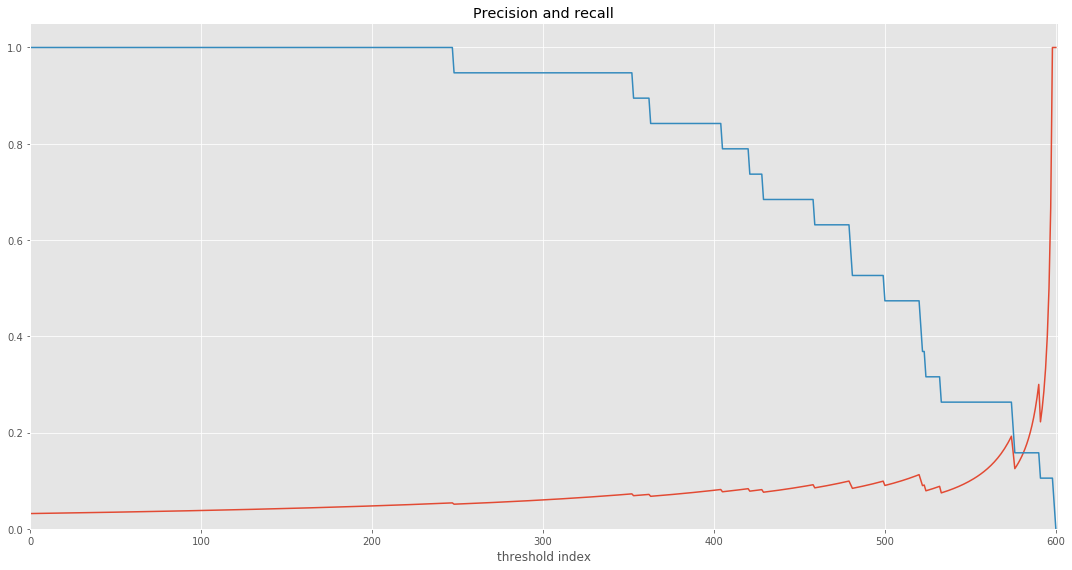

In [10]:
area, precisions, recalls, thresholds = calculate_auc(results)

DummyDetector(strategy='stratified', constant=None, contamination=0.1) 

| Trained detector and scored features: 0.1 seconds
| Created segments: 0.7 seconds
| Created results DataFrame: 1.0 seconds
| Results DataFrame check: 0.0 seconds


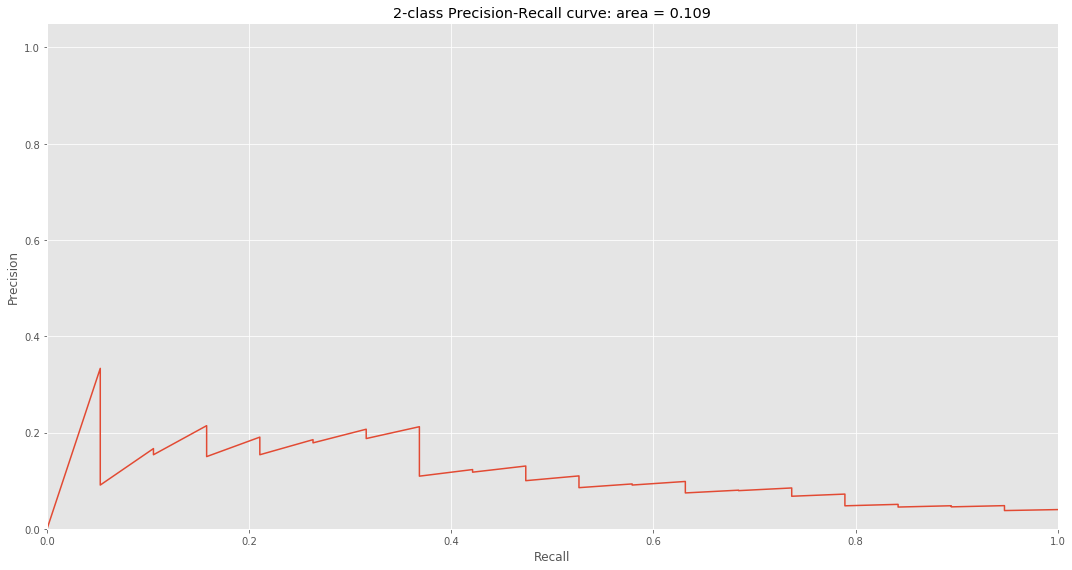

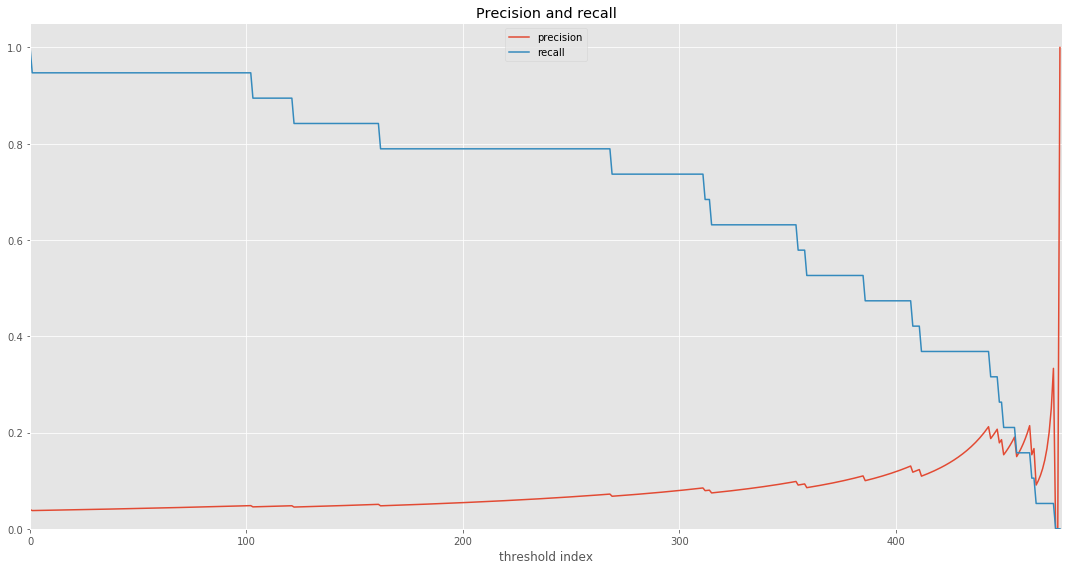

PR-curve tresholds: 476, min: 0.83, max: 1.00
Area under PR curve = 0.10948796340233605
| Evaluation: 0.3 seconds
| Pipeline execution time: 2.2 seconds



In [11]:
results, auc, precision, recall, thresholds = pipeline.pipeline(
    df, 
    labels,
    anomaly_detector="dummy_stratified",
    detector_parameters={"contamination": 0.1},
    scale_data = True,
    verbose=True, 
    show_figures=True
)

trapz 1: 0.08159208813313153 trapz 2: 0.11159056480224672
area 0.11325875479979816


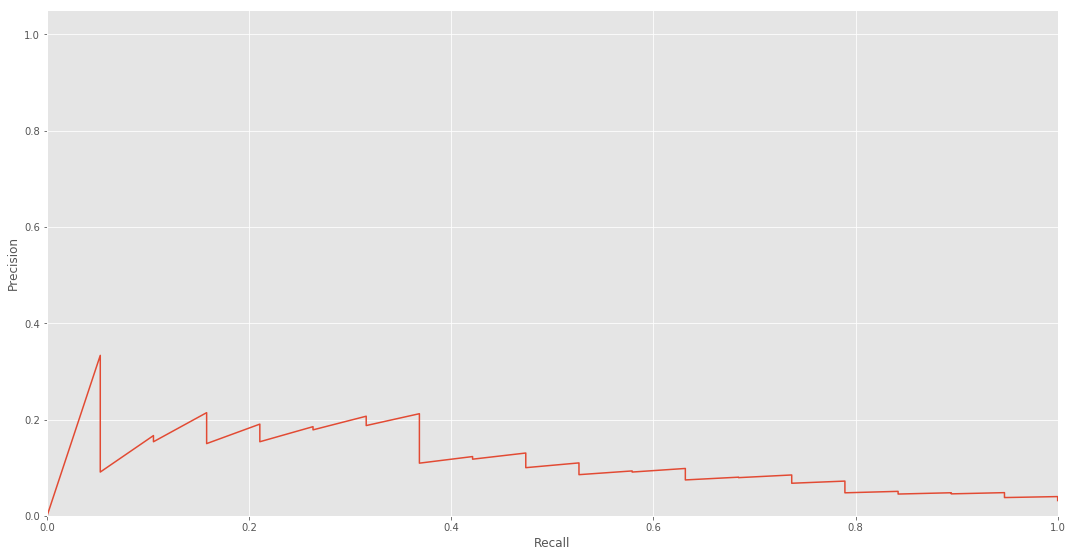

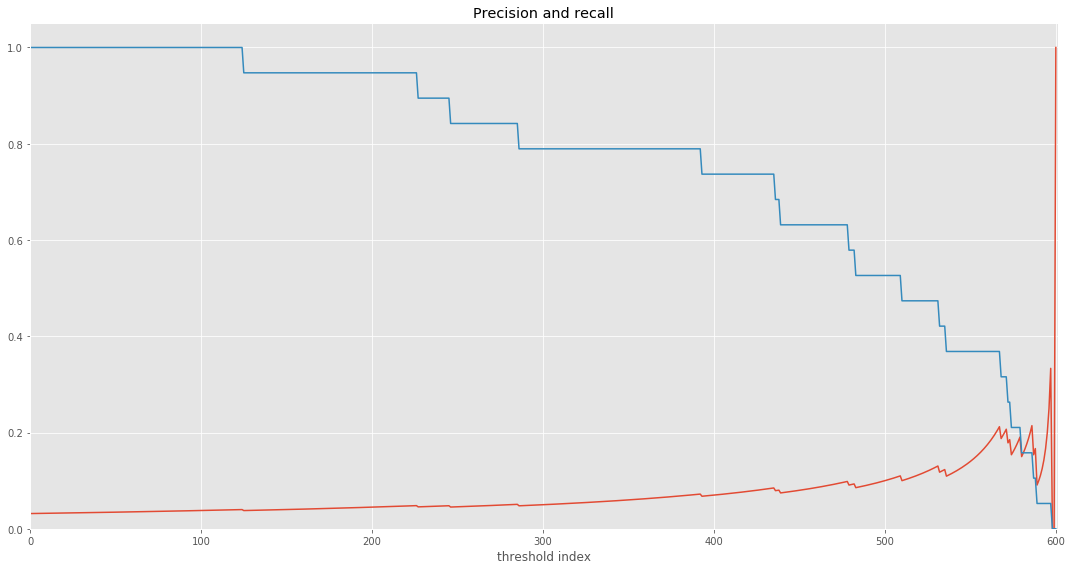

In [12]:
area, precisions, recalls, thresholds = calculate_auc(results)